In [6]:
import pandas as pd
from pathlib import Path
import os

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append(os.path.abspath('..'))

from util import evaluate_model_performance, evaluate_model_fairness

In [7]:
data_path = Path(os.getcwd()).parent.parent / "data" / "dataset_diabetes"
df = pd.read_csv(data_path / "diabetic_preprocessed.csv")

In [8]:
df["age"] = df["age_all"]

columns_to_remove = ['encounter_id', 'patient_nbr', 'readmitted', 'readmit_binary', 'diabetes_type', \
    'had_emergency', 'had_inpatient_days', 'had_outpatient_days', 'race_all', 'age_all']

df_for_experimenting = df.drop(columns=columns_to_remove)

## Prepare training and test datasets

In [9]:
target_variable = "readmit_30_days"
Y= df_for_experimenting.loc[:, target_variable]

In [10]:
X = pd.get_dummies(df_for_experimenting.drop(columns=["readmit_30_days"]))

In [11]:
X.head() # sanity check

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Caucasian,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,0,0,0,1,0,1,...,1,0,1,0,1,0,0,1,1,0
1,3,59,0,18,0,0,0,9,0,1,...,1,0,1,0,1,0,1,0,0,1
2,2,11,5,13,2,0,1,6,1,0,...,1,0,1,0,1,0,0,1,0,1
3,2,44,1,16,0,0,0,7,0,1,...,1,0,1,0,1,0,1,0,0,1
4,1,51,0,8,0,0,0,5,0,1,...,1,0,1,0,1,0,1,0,0,1


In [12]:
random_seed = 445
np.random.seed(random_seed)

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.20,
    stratify=Y,
    random_state=random_seed
)

### Grid search cross-validation adjusted weights using balanced accuracy as the estimator

In [13]:
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,50)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator=lr, 
                          param_grid=param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='balanced_accuracy', 
                          verbose=2).fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Text(0.5, 1.0, 'Scoring for different class weights')

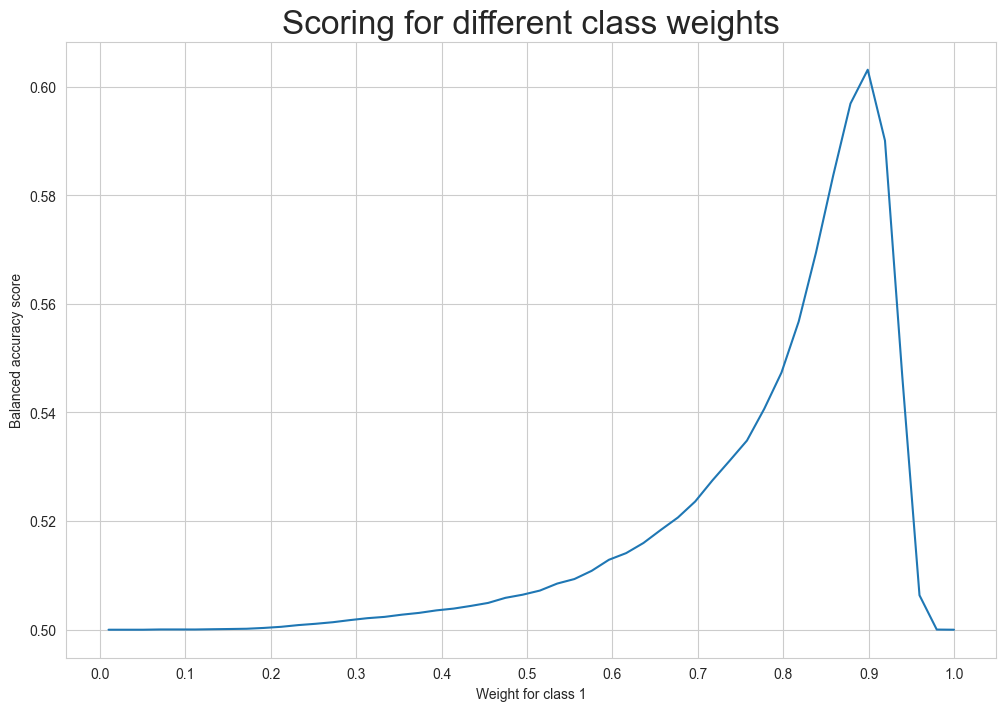

In [14]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({'weight':(1-weights), 'score':gridsearch.cv_results_['mean_test_score']})
sns.lineplot(x=weigh_data['weight'], y=weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Balanced accuracy score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [15]:
max_y = max(weigh_data['score'])  # Find the maximum y value
max_x = weigh_data['weight'][weigh_data['score'].argmax()]  # Find the x value corresponding to the maximum y value
print (f"X={max_x} corresponds to the max Y={max_y}")

X=0.8989795918367347 corresponds to the max Y=0.6031136874434847


In [16]:
lr = LogisticRegression(solver='newton-cg', class_weight={0: 1-0.8989795918367347, 1: 0.8989795918367347})
lr.fit(X_train, Y_train)

# Predicting on the test data
pred_test = lr.predict(X_test)
evaluate_model_performance(Y_test, pred_test)

The accuracy score for the testing data: 0.579079251216037
The balanced accuracy score for the testing data: 0.6008163748968628
The precision score for the testing data: 0.15603146853146854
The recall score for the testing data: 0.6287978863936592
The F1 score for the testing data: 0.25002188566926375
The F2 score for the testing data: 0.39153323097170434
The G mean score for the testing data: 0.6001644369325478
